In [306]:
# Import Statements
import project_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (train_test_split, 
                                     RandomizedSearchCV, 
                                     cross_val_score,
                                     RepeatedStratifiedKFold
                                    )
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.ensemble import (RandomForestRegressor, 
                              RandomForestClassifier
                             )
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, 
                             precision_score, 
                             recall_score, 
                             #roc_auc_score, 
                             #roc_curve, 
                             f1_score
                            )
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder
                                  )
from sklearn.compose import make_column_transformer
from pprint import pprint
from sklearn.pipeline import make_pipeline
from numpy import (mean, 
                   std
                  )
#from numpy import std
from sklearn.datasets import make_classification
from sklearn.tree import export_graphviz
from scipy.stats import mode as sc_mode
#from funct import *

pd.set_option('display.max_columns', None)
%matplotlib inline

In [307]:
def hello_world():
    return 'Hello World'

In [308]:
hello_world()

'Hello World'

In [309]:
replace_na_col = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
                  'GarageQual', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageYrBlt',
                  'GarageQual', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1',
                  'BsmtFinType2'
                 ]
fields_to_drop = ['LotFrontage', 'GarageYrBlt', 'Utilities', 'Street', 'GarageArea',
                      'YearRemodAdd', 'BsmtFinSF1', 'ScreenPorch', 'EnclosedPorch', 'Alley',
                      'Utilities', 'SaleType', '3SsnPorch', 'Exterior1st', 'Exterior2nd',
                      'Condition1', 'Condition2', 'PoolArea', 'Functional', 'RoofMatl',
                      'RoofStyle', 'Electrical', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2',
                      'PoolQC', 'HeatingQC', 'BsmtExposure', 'PoolQC', 'BsmtUnfSF', 
                      'SaleCondition', 'LotConfig', 'TotalBsmtSF', 'MSSubClass', 'LowQualFinSF',
                      'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'WoodDeckSF', 'LandSlope',
                      'WoodDeckSF'
                     ]
fields_to_drop_sm = ['LotFrontage', 'GarageYrBlt']


In [310]:
def unique_counts (df):
    ret = []
    ret = pd.DataFrame.from_records([(col, df[col].nunique(), df[col].dtype) for col in df.columns],
                          columns=['Column', 'Num_Unique', 'type']).sort_values(by=['Num_Unique'])
    return ret

def convert_to_cat(df, type_):
    unique_ = unique_counts(df)
    for col in unique_['Column'].loc[unique_['Num_Unique']<20]:
        if df[col].dtype == type_:
            #if unique_[col].loc[unique_['Num_Unique']<20]:
        #train_x[col] = pd.cut(train_x[col], bins=4, labels=[col+'_low', col+'_mid', col+'_high', col+'_very_high'])
            df[col] = df[col].astype('str').astype('category')
    for col in unique_['Column'].loc[unique_['Num_Unique']>=20]:
        if df[col].dtype == type_:
            df[col] = pd.qcut(df[col], 6, duplicates='drop')#bins=4, labels=['_low', '_mid', '_high', '_very_high'])
            df[col] = df[col].astype('str').astype('category')
    return df


def change_missing(df, col_=replace_na_col, val='NA'):
    df[col_] = df[col_].replace({np.nan: val})
    return df

def cond_condense_rooms(cond_, expand=True):
        cond_ = int(cond_)
        if expand:
            return cond_
        if cond_ < 3:
            return 1
        if cond_ < 5:
            return 2
        if cond_ < 10:
            return 3
        else:
            return 0
        
def cond_tot_rooms(cond_, expand=True):
    cond_ = int(cond_)
    if expand:
        return cond_
    if cond_ < 5:
        return 1
    if cond_ < 7:
        return 2
    if cond_ < 10:
        return 3
    else:
        return 4    

def qu_condense(cond_, expand=True):
    if expand:
        if cond_ == 'Ex':
            return 4
        elif cond_ == 'Gd':
            return 3
        elif cond_ == 'TA':
            return 2
        elif cond_ == 'Fa':
            return 1
        else:
            return 0
    else:
        if cond_ in ['Ex', 'Gd']:
            return 3
        if cond_ == 'TA':
            return 2
        if cond_ in ['Fa', 'Po']:
            return 1
        else:
            return 0

def cond_condenser(cond_, expand=True):
    cond_ = int(cond_)
    if expand:
        return cond_
    if cond_ < 3:
        return 1
    elif cond_ < 6:
        return 2
    elif cond_ < 7:
        return 3
    elif cond_ <9:
        return 4
    elif cond_ < 11:
        return 5
    else:
        return 0


In [438]:
# create a setup function that gets the data in the structure I need
def data_load():
    ''' Basic data load and setup. Just loading one of the files - train.csv, splitting
    into a train_x and train_y. Bin some of the data and delete a bunch of the columns
    that after many iterations, didn't need to be included. All data becomes category data
    '''
    import pandas as pd
    train = pd.read_csv('data/train.csv')
    train_x = train.iloc[:,:-1].drop('Id', axis=1)
    fields_ = ['MasVnrArea', 'Electrical', 'MSZoning', 'Functional', 'Utilities']
    
    val_ = []
    for f in (fields_):
        train_x[f] = train_x[f].fillna(train_x[f].mode()[0])
        
    train_y = train.iloc[:,-1]
    train_x = change_missing(train_x)
     
    # bin y
    bin_ = (np.linspace(0, 800000, 32))
    #bin_ = np.concatenate((np.linspace(25000, 450000, 9),np.array([500000, 550000, 600000, 800000]) ) )
    y_cat_type = pd.CategoricalDtype(categories=list(range(0,len(bin_)-1)), ordered=True)
    #train_y = pd.cut(train_y, bins=bin_).astype('str').astype('category')
    train_y = pd.cut(train_y, bins=bin_, labels=list(range(0,len(bin_)-1))).astype(y_cat_type)
       
    for col_ in ['FireplaceQu', 'KitchenQual', 'BsmtCond', 'ExterCond', 'ExterCond',
                 'BsmtQual', 'GarageCond', 'GarageQual']:
        train_x[col_] = train_x[col_].apply(lambda x: qu_condense(x))  
    train_x['OverallCond'] = train_x['OverallCond'].apply(lambda x: cond_condenser(x))
    train_x['OverallQual'] = train_x['OverallQual'].apply(lambda x: cond_condenser(x))
    train_x['BedroomAbvGr'] = train_x['BedroomAbvGr'].apply(lambda x: cond_condense_rooms(x))
    train_x['TotRmsAbvGrd'] = train_x['TotRmsAbvGrd'].apply(lambda x: cond_tot_rooms(x))   
    for col in train_x:
        if train_x[col].dtype == 'object':
            train_x[col] = train_x[col].astype('str').astype('category')
            #train_x[col] = train_x[col].astype(CategoricalDtype(list(0:len()))).astype('category')
#     for col in test_x:
#         if test_x[col].dtype == 'object':
#             test_x[col] = test_x[col].astype('str').astype('category')
    # bin the data
    train_x['LotShape'] = train_x['LotShape'].apply(lambda x: '1' if x == 'Reg' else '0')
    train_x = convert_to_cat(train_x, 'int64')
    train_x = convert_to_cat(train_x, 'float64')
    train_x = train_x.drop(fields_to_drop, axis=1)
    return train_x, train_y, train

def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)

def by_cat_dist_plot(data_column, name_):
    ax=data_column.value_counts().plot(kind = 'bar',  
                                                  figsize=(9,6)) #.sort_index() after counts()
    ax.set_title(name_, fontname='Comic Sans MS', fontsize=20)




In [439]:
# using the data_load function to get the data as I need it for this part of the project
train_x, train_y, train_raw = data_load()

In [440]:
(train_y)

0        8
1        7
2        8
3        5
4        9
        ..
1455     6
1456     8
1457    10
1458     5
1459     5
Name: SalePrice, Length: 1460, dtype: category
Categories (31, int64): [0 < 1 < 2 < 3 ... 27 < 28 < 29 < 30]

In [441]:
# Finding the Neighborhoods with the highest number of counts
# will take top 3 neighborhoods and will do all neighborhoods including top 3
train_x.groupby('Neighborhood')['OverallCond'].count().sort_values(ascending=False).head(15).reset_index()

,Neighborhood,OverallCond
0,NAmes,225
1,CollgCr,150
2,OldTown,113
3,Edwards,100
4,Somerst,86
5,Gilbert,79
6,NridgHt,77
7,Sawyer,74
8,NWAmes,73
9,SawyerW,59


In [442]:
# looking at the number of unique values per category

pd.DataFrame.from_records([(col, train_x[col].nunique()) for col in train_x.columns],
                          columns=['Column', 'Num_Unique']).sort_values(by=['Num_Unique'])

,Column,Num_Unique
39,MiscVal,1
13,ExterCond,1
2,LotShape,2
18,CentralAir,2
20,2ndFlrSF,3
23,HalfBath,3
35,PavedDrive,3
11,MasVnrArea,3
12,ExterQual,4
31,GarageFinish,4


from the random grid search I did

{'n_estimators': 1700,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 36,
 'max_features': 0.2,
 'max_depth': 4,
 'bootstrap': True}

In [443]:
# setup classifier these parameters were created from numerous runs on the full data set
# for testing set true, else false for full run
quick_ = False
if quick_:
    rf_classifier = RandomForestClassifier(
                      min_samples_leaf=2,
                      min_samples_split=10,
                      n_estimators=700,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=22,
                      max_depth=2,
                      max_features=5)
else:
    rf_classifier = RandomForestClassifier(
                      min_samples_leaf=2,
                      min_samples_split=10,
                      n_estimators=1700,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=22,
                      max_depth=4,
                      max_features=5)

# rf_classifier = RandomForestClassifier(
#                       min_samples_leaf=10,
#                       n_estimators=val_[0],
#                       bootstrap=True,
#                       oob_score=True,
#                       n_jobs=-1,
#                       random_state=22,
#                       max_features=val_[1])

In [444]:
'''making copy of the train_x data so I don't change it during this process - also adding
the saleprice back in so that when I group data it will all be matched'''

train_xy=train_x.copy()
train_xy['SalePrice'] =train_y
train_xy

,MSZoning,LotArea,LotShape,LandContour,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,Heating,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,OpenPorchSF,Fence,MiscFeature,MiscVal,MoSold,YrSold,SalePrice
0,RL,"(8400.0, 9478.5]",1,Lvl,CollgCr,1Fam,2Story,7,5,"(1994.0, 2004.0]",BrkFace,"(93.333, 243.833]",Gd,0,PConc,3,2,GasA,Y,"(816.0, 948.333]","(846.0, 2065.0]","(1664.667, 1958.0]",2,1,3,1,3,8,0,0,Attchd,RFn,2,2,2,Y,"(50.0, 98.0]",NA,NA,"(-0.001, 15500.0]",2,2008,8
1,RL,"(9478.5, 10766.0]",1,Lvl,Veenker,1Fam,1Story,6,8,"(1973.0, 1994.0]",None,"(-0.001, 93.333]",TA,0,CBlock,3,2,GasA,Y,"(1087.0, 1266.0]","(-0.001, 600.0]","(1242.667, 1464.0]",2,0,3,1,2,6,1,2,Attchd,RFn,2,2,2,Y,"(-0.001, 25.0]",NA,NA,"(-0.001, 15500.0]",5,2007,7
2,RL,"(10766.0, 12799.667]",0,Lvl,CollgCr,1Fam,2Story,7,5,"(1994.0, 2004.0]",BrkFace,"(93.333, 243.833]",Gd,0,PConc,3,2,GasA,Y,"(816.0, 948.333]","(846.0, 2065.0]","(1664.667, 1958.0]",2,1,3,1,3,6,1,2,Attchd,RFn,2,2,2,Y,"(25.0, 50.0]",NA,NA,"(-0.001, 15500.0]",9,2008,8
3,RL,"(9478.5, 10766.0]",0,Lvl,Crawfor,1Fam,2Story,7,5,"(1871.999, 1940.0]",None,"(-0.001, 93.333]",TA,0,BrkTil,2,3,GasA,Y,"(948.333, 1087.0]","(600.0, 846.0]","(1664.667, 1958.0]",1,0,3,1,3,7,1,3,Detchd,Unf,3,2,2,Y,"(25.0, 50.0]",NA,NA,"(-0.001, 15500.0]",2,2006,5
4,RL,"(12799.667, 215245.0]",0,Lvl,NoRidge,1Fam,2Story,8,5,"(1994.0, 2004.0]",BrkFace,"(243.833, 1600.0]",Gd,0,PConc,3,2,GasA,Y,"(1087.0, 1266.0]","(846.0, 2065.0]","(1958.0, 5642.0]",2,1,4,1,3,9,1,2,Attchd,RFn,3,2,2,Y,"(50.0, 98.0]",NA,NA,"(-0.001, 15500.0]",12,2008,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,"(6405.0, 8400.0]",1,Lvl,Gilbert,1Fam,2Story,6,5,"(1994.0, 2004.0]",None,"(-0.001, 93.333]",TA,0,PConc,3,2,GasA,Y,"(948.333, 1087.0]","(600.0, 846.0]","(1464.0, 1664.667]",2,1,3,1,2,7,1,2,Attchd,RFn,2,2,2,Y,"(25.0, 50.0]",NA,NA,"(-0.001, 15500.0]",8,2007,6
1456,RL,"(12799.667, 215245.0]",1,Lvl,NWAmes,1Fam,1Story,6,6,"(1973.0, 1994.0]",Stone,"(93.333, 243.833]",TA,0,CBlock,3,2,GasA,Y,"(1535.833, 4692.0]","(-0.001, 600.0]","(1958.0, 5642.0]",2,0,3,1,2,7,2,2,Attchd,Unf,2,2,2,Y,"(-0.001, 25.0]",MnPrv,NA,"(-0.001, 15500.0]",2,2010,8
1457,RL,"(8400.0, 9478.5]",1,Lvl,Crawfor,1Fam,2Story,7,9,"(1940.0, 1960.0]",None,"(-0.001, 93.333]",Ex,0,Stone,2,3,GasA,Y,"(1087.0, 1266.0]","(846.0, 2065.0]","(1958.0, 5642.0]",2,0,4,1,3,9,2,3,Attchd,RFn,1,2,2,Y,"(50.0, 98.0]",GdPrv,Shed,"(-0.001, 15500.0]",5,2010,10
1458,RL,"(9478.5, 10766.0]",1,Lvl,NAmes,1Fam,1Story,5,6,"(1940.0, 1960.0]",None,"(-0.001, 93.333]",TA,0,CBlock,2,2,GasA,Y,"(948.333, 1087.0]","(-0.001, 600.0]","(1026.0, 1242.667]",1,0,2,1,3,5,0,0,Attchd,Unf,1,2,2,Y,"(-0.001, 25.0]",NA,NA,"(-0.001, 15500.0]",4,2010,5


<AxesSubplot:>

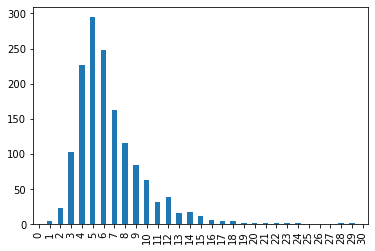

In [445]:
train_xy['SalePrice'].value_counts().sort_index().plot(kind = 'bar')

In [446]:
def top_feature_plot(feature_imp_ranked_, num=20):    
    feature_names_ = [i[0] for i in feature_imp_ranked_[:num]]
    y_ticks = np.arange(0, len(feature_names_))
    x_axis = [i[1] for i in feature_imp_ranked_[:num]]
    plt.figure(figsize = (10, 10))
    plt.barh(feature_names_, x_axis)   #horizontal barplot
    plt.title('Random Forest Feature Importance',
              fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
    plt.xlabel('Features',fontdict= {'fontsize' : 16})
    plt.show()

In [447]:
def feature_imp_lst(enc_, imp_, num=num_):
    feature_importances_ = list(zip(enc_, imp_))    
    feature_importances_ranked_ = sorted(feature_importances_, key = lambda x: x[1], reverse = True)
    [print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked_[:num]]; 
    return feature_importances_ranked_

    

In [448]:
feature_importances_ranked_

[('ExterQual_TA', 0.04077753992025949),
 ('FullBath_1', 0.03786231743874378),
 ('FullBath_2', 0.03539196614234247),
 ('ExterQual_Gd', 0.03394096397786369),
 ('KitchenQual_2', 0.031830039090380444),
 ('GrLivArea_(333.999, 1026.0]', 0.026097345724143076),
 ('KitchenQual_3', 0.02522215793993021),
 ('GarageCars_2', 0.025140019571696),
 ('Foundation_PConc', 0.023967390813889204),
 ('BsmtQual_2', 0.02228816432434007),
 ('GarageType_Attchd', 0.02207267901747973),
 ('BsmtQual_3', 0.0213139094998593),
 ('GarageFinish_Unf', 0.020553047120608788),
 ('GrLivArea_(1958.0, 5642.0]', 0.019540704010499635),
 ('GarageCars_3', 0.018953493178431077),
 ('OverallQual_7', 0.0189055049525403),
 ('FireplaceQu_0', 0.018255308426503723),
 ('GarageCars_1', 0.018215141353820047),
 ('OverallQual_8', 0.018202558744537058),
 ('Fireplaces_0', 0.017642068665362227),
 ('GarageType_Detchd', 0.01636059468392241),
 ('OpenPorchSF_(-0.001, 25.0]', 0.01570571873384568),
 ('2ndFlrSF_(846.0, 2065.0]', 0.015373757077435764),
 ('

In [402]:
def sum_dict(dict_):
    return {k: sum(v) for k,v in dict_.items()}

def sort_dict(dict_):
    return {k: dict_[k] for k in sorted(dict_, key=dict_.get, reverse=True)}

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


NAmes
 There are 177 features in total
Feature: BsmtQual_3                          Importance: 0.042108363948735454
Feature: Heating_OthW                        Importance: 0.039312600410720086
Feature: KitchenAbvGr_3                      Importance: 0.03531037920752778
Feature: KitchenQual_4                       Importance: 0.032127363660498225
Feature: HouseStyle_2Story                   Importance: 0.02899193967528045
Feature: MasVnrArea_(-0.001, 93.333]         Importance: 0.026099103552168733
Feature: OverallCond_7                       Importance: 0.025374529190106184
Feature: OverallCond_6                       Importance: 0.02493928551655386
Feature: Heating_Grav                        Importance: 0.022495620683127902
Feature: OverallCond_9                       Importance: 0.02182520541957088


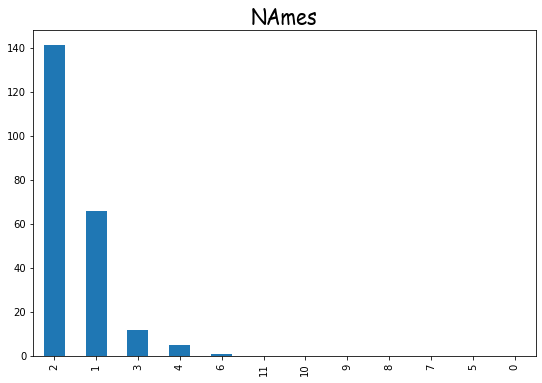

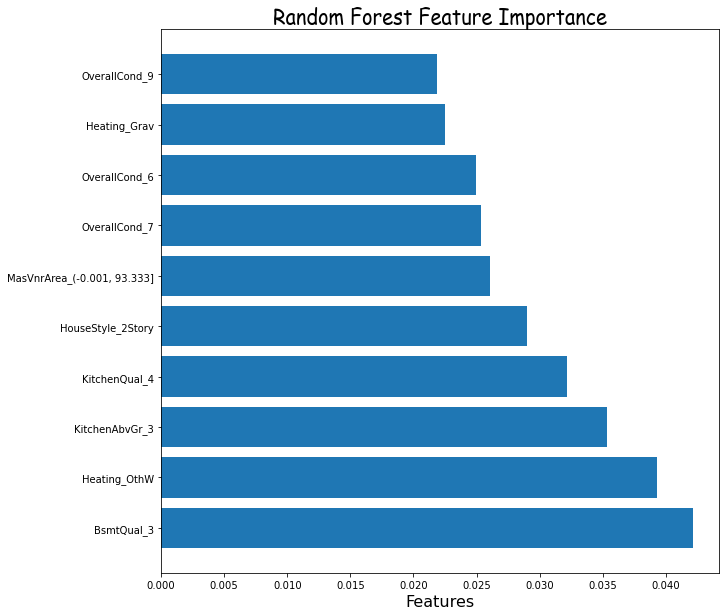

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


CollgCr
 There are 143 features in total
Feature: HouseStyle_2.5Unf                   Importance: 0.051753396649257634
Feature: Foundation_PConc                    Importance: 0.04820247122991503
Feature: Foundation_Slab                     Importance: 0.047914269106493185
Feature: BedroomAbvGr_8                      Importance: 0.04540442394891125
Feature: Foundation_Stone                    Importance: 0.04539852456536408
Feature: HouseStyle_1Story                   Importance: 0.03551308855114158
Feature: BsmtCond_3                          Importance: 0.02678915159850952
Feature: BsmtCond_2                          Importance: 0.025203916225753943
Feature: OverallCond_8                       Importance: 0.02309388277128313
Feature: FullBath_1                          Importance: 0.021251022202786282


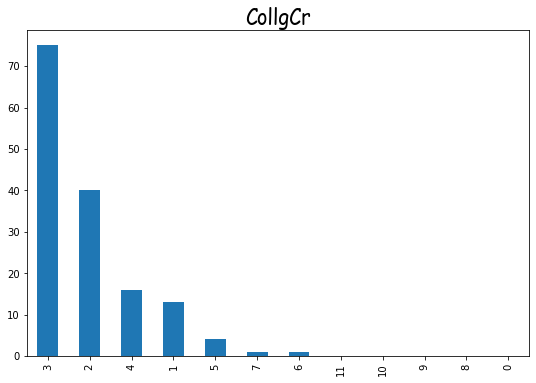

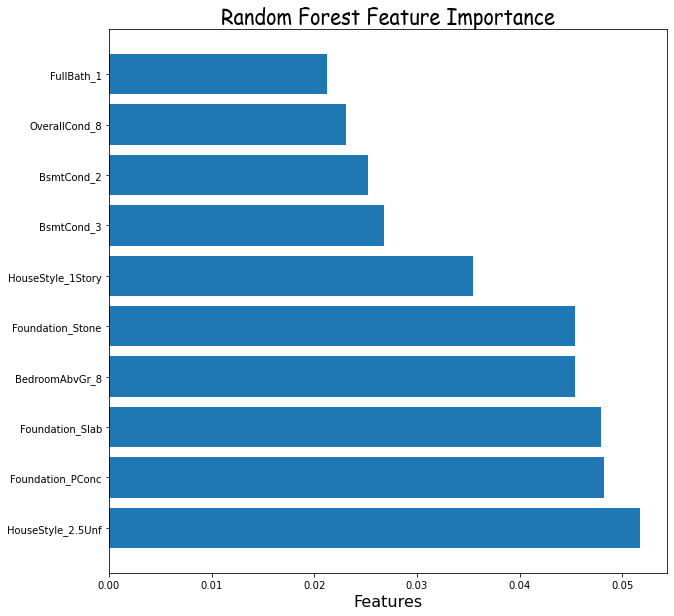

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


OldTown
 There are 175 features in total
Feature: OverallQual_10                      Importance: 0.03043561027358622
Feature: BedroomAbvGr_4                      Importance: 0.026908798976380235
Feature: BsmtCond_1                          Importance: 0.02478805213354518
Feature: BedroomAbvGr_5                      Importance: 0.02383347466131991
Feature: 2ndFlrSF_(-0.001, 600.0]            Importance: 0.022417618785166217
Feature: Heating_Grav                        Importance: 0.022055044594766753
Feature: OverallQual_9                       Importance: 0.021450559365640165
Feature: BedroomAbvGr_8                      Importance: 0.02138662362051335
Feature: LotArea_(1299.999, 6405.0]          Importance: 0.020543595900678707
Feature: BsmtCond_2                          Importance: 0.020515698076076522


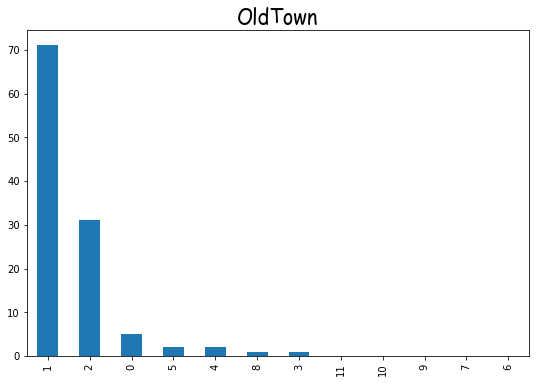

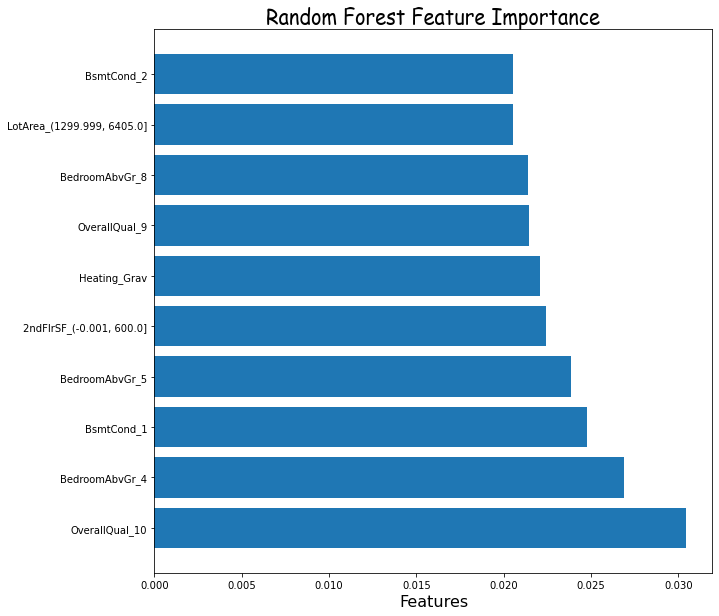

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


ALL
 There are 206 features in total
Feature: ExterQual_TA                        Importance: 0.04077753992025949
Feature: FullBath_1                          Importance: 0.03786231743874378
Feature: FullBath_2                          Importance: 0.03539196614234247
Feature: ExterQual_Gd                        Importance: 0.03394096397786369
Feature: KitchenQual_2                       Importance: 0.031830039090380444
Feature: GrLivArea_(333.999, 1026.0]         Importance: 0.026097345724143076
Feature: KitchenQual_3                       Importance: 0.02522215793993021
Feature: GarageCars_2                        Importance: 0.025140019571696
Feature: Foundation_PConc                    Importance: 0.023967390813889204
Feature: BsmtQual_2                          Importance: 0.02228816432434007


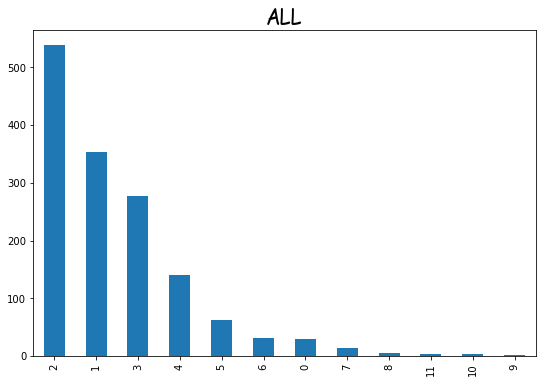

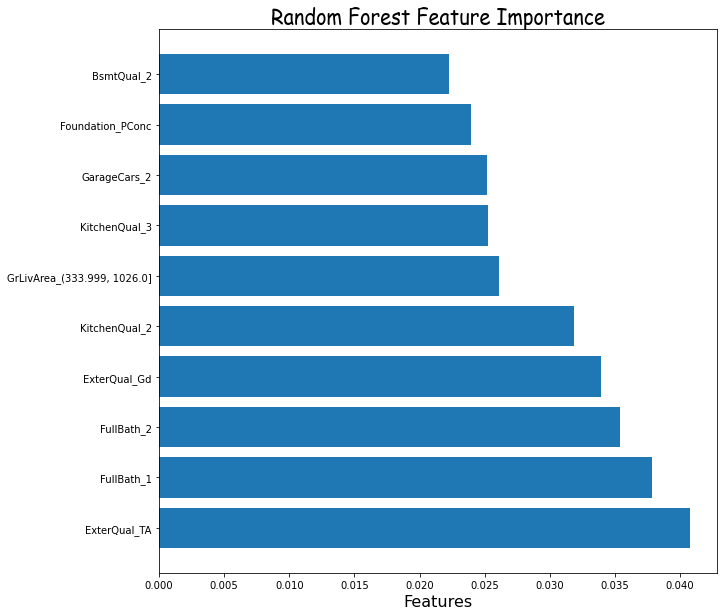

In [403]:
# declare dictionare that gets created of features
cat_t = {}
top_features = []
top_ = ['NAmes', 'CollgCr', 'OldTown', 'ALL']#, 'Edwards', 'Somerst']
top_dicts = []
for name in top_:
    if name == 'ALL':
        name_ = train_xy
    else:
        name_ = train_xy.loc[train_xy['Neighborhood'] == name].reset_index(drop=True)
    # why I drop the Nieghborhood? it's because so much of the other variables are baked
    # into the neighborhood, that it overfits the data too easily (other option would be to
    # drop other related columns or decrease the weight -)
    t_x = name_.iloc[:,1:].drop(['Neighborhood', 'SalePrice'], axis=1)
    t_y = name_.iloc[:,-1:]

    col_trans = make_column_transformer(
                        (OneHotEncoder(),t_x.columns.tolist()),
                        remainder = "passthrough"
                        )
    pipe = make_pipeline(col_trans, rf_classifier)
    pipe.fit(t_x, t_y)
    print(name)
    by_cat_dist_plot(t_y['SalePrice'], name)
    #t_y['SalePrice'].value_counts().sort_index().plot(kind = 'bar', title=name, figsize=(9,6))
    print(f" There are {len(rf_classifier.feature_importances_)} features in total")
    X_t_encoded = encode_and_bind(t_x, t_x.columns.tolist())
    feature_importances_ranked_ = feature_imp_lst(X_t_encoded, rf_classifier.feature_importances_)
    top_features.append([name, feature_importances_ranked_])
    top_feature_plot(feature_importances_ranked_, 10)
    
    
# Dictionary of Features and importances greater than .0001
# cat_ dict is all results top_five_dicts is list of dictionaries by neighborhood
    cat_new = {}
    for feat in feature_importances_ranked_[:35]:     
        if feat[1] > 0.0001:
            cat_t.setdefault(feat[0].split(sep='_')[0], []).append(feat[1])
            cat_new.setdefault(feat[0].split(sep='_')[0], []).append(feat[1])
    top_dicts.append(cat_new)

In [404]:
sort_dict(cat_new)

{'ExterQual': [0.04077753992025949, 0.03394096397786369],
 'FullBath': [0.03786231743874378, 0.03539196614234247],
 'KitchenQual': [0.031830039090380444, 0.02522215793993021],
 'GrLivArea': [0.026097345724143076, 0.019540704010499635],
 'GarageCars': [0.025140019571696, 0.018953493178431077, 0.018215141353820047],
 'Foundation': [0.023967390813889204, 0.01234566285135022],
 'BsmtQual': [0.02228816432434007, 0.0213139094998593, 0.011345291492623432],
 'GarageType': [0.02207267901747973, 0.01636059468392241],
 'GarageFinish': [0.020553047120608788, 0.010592711997220798],
 'OverallQual': [0.0189055049525403,
  0.018202558744537058,
  0.014059364576602578,
  0.010931966890166527,
  0.010565248570397921],
 'FireplaceQu': [0.018255308426503723],
 'Fireplaces': [0.017642068665362227, 0.010828739789386723],
 'OpenPorchSF': [0.01570571873384568],
 '2ndFlrSF': [0.015373757077435764],
 '1stFlrSF': [0.011844246578279398, 0.00901241517292279],
 'YearBuilt': [0.009484246490848993, 0.0090081447669558

In [405]:
count_=[]
tot_=[]
for val in top_dicts:
    print(val)
    print('*'*100)
    val = sum_dict(val)
    
    for k,v in sort_dict(val).items():
        print(k,v)
        count_.append(k)
    print('*'*100)

{'BsmtQual': [0.042108363948735454, 0.01118543481669267, 0.008567154457729575], 'Heating': [0.039312600410720086, 0.022495620683127902, 0.012849713272998048, 0.01153106147743065], 'KitchenAbvGr': [0.03531037920752778], 'KitchenQual': [0.032127363660498225], 'HouseStyle': [0.02899193967528045, 0.015508523703666368, 0.010194520092550606], 'MasVnrArea': [0.026099103552168733], 'OverallCond': [0.025374529190106184, 0.02493928551655386, 0.02182520541957088], 'BedroomAbvGr': [0.02166417802381597, 0.01557229014360445], 'TotRmsAbvGrd': [0.021463913892767066, 0.018434425576605816], 'ExterQual': [0.020914927838211722, 0.020213556112749144], 'FullBath': [0.017299550675255473], '1stFlrSF': [0.016777827447300348, 0.013016613087546163, 0.011072533171622793], 'LotArea': [0.016663382981253038], 'CentralAir': [0.01508414434240289, 0.011659373686968203], 'HalfBath': [0.014980393960096218], 'Foundation': [0.01287788010893073], 'MasVnrType': [0.012474932064390841], 'OverallQual': [0.009920837854441814, 0.

In [449]:
#print(train_x)
for val_ in ['OverallQual','Heating', 'HouseStyle', 'ExterQual', 'LotArea', 'Foundation', 'TotRmsAbvGrd', 'BsmtCond']:
    print(train_x.loc[train_x['Neighborhood']=='CollgCr'][['Neighborhood', val_]].groupby(val_).count())



             Neighborhood
OverallQual              
1                       0
10                      0
2                       0
3                       0
4                       1
5                      28
6                      24
7                      71
8                      23
9                       3
         Neighborhood
Heating              
Floor               0
GasA              150
GasW                0
Grav                0
OthW                0
Wall                0
            Neighborhood
HouseStyle              
1.5Fin                 0
1.5Unf                 0
1Story                91
2.5Fin                 0
2.5Unf                 0
2Story                53
SFoyer                 3
SLvl                   3
           Neighborhood
ExterQual              
Ex                    0
Fa                    0
Gd                  109
TA                   41
                       Neighborhood
LotArea                            
(10766.0, 12799.667]             29
(12799.667

In [450]:
train_xy['SalePrice_real']= train_raw['SalePrice']

In [451]:
print(train_xy.groupby('Neighborhood', dropna=True).agg(agg_setup).round())
                  #.agg({'Neighborhood':'count', 'SalePrice_real': ['mean', 'min', 'max', 'std'], 
                  #                                                 'SalePrice': sc_mode}))

             GarageQual SalePrice_real                                    \
                  count           mean  median     min     max       std   
Neighborhood                                                               
Blmngtn              17       194871.0  191000  159895  264561   30393.0   
Blueste               2       137500.0  137500  124000  151000   19092.0   
BrDale               16       104494.0  106000   83000  125000   14330.0   
BrkSide              58       124834.0  124300   39300  223500   40349.0   
ClearCr              28       212565.0  200250  130000  328000   50232.0   
CollgCr             150       197966.0  197200  110000  424870   51404.0   
Crawfor              51       210625.0  200624   90350  392500   68866.0   
Edwards             100       128220.0  121750   58500  320000   43209.0   
Gilbert              79       192855.0  181000  141000  377500   35987.0   
IDOTRR               37       100124.0  103000   34900  169500   33377.0   
MeadowV     

In [452]:
#val_dict = sum_dict(top_dicts[0:2])
train_xy['SalePrice_real']= train_raw['SalePrice']
train_xy['SalePrice'] = train_y#['SalePrice']
agg_setup = ({k:'count', 'SalePrice_real': ['mean', 'median', 'min', 'max', 'std'], 'SalePrice': sc_mode})
agg_setup_raw = ({k:'count', 'SalePrice': ['mean', 'min', 'max', 'std'], 'SalePrice': sc_mode})
def dict_value_mean(dict_, neigh_):
    for k,v in sort_dict(dict_).items():
        print(neigh_, k, v)
        if neigh_ == 'ALL':
            print(train_xy.groupby(k, dropna=True)
                  .agg(agg_setup).round(0))#count())
            print(train_raw.groupby(k, dropna=True)
                  .agg(agg_setup_raw))
            
        else:
            print(train_xy.loc[train_xy['Neighborhood']==neigh_][['Neighborhood','SalePrice_real', k]].groupby(k)
                 # .agg(agg_setup))#
                  .agg({k:'count', 'SalePrice_real': 'mean'}))#count())
            print(train_raw.loc[train_x['Neighborhood']==neigh_][['Neighborhood','SalePrice', k]].groupby(k, dropna=True)
                  .agg({k:'count', 'SalePrice': 'mean'}))
    print('*'*100)

In [493]:
for n in range(0,len(top_)):
    val_dict = sum_dict(top_dicts[n])
    dict_value_mean(val_dict, top_[n])


NAmes Heating 0.08618899584427668
         Heating  SalePrice_real
Heating                         
Floor          0             NaN
GasA         221   146611.733032
GasW           1   144000.000000
Grav           0             NaN
OthW           0             NaN
Wall           3    90133.333333
         Heating      SalePrice
Heating                        
GasA         221  146611.733032
GasW           1  144000.000000
Wall           3   90133.333333
NAmes OverallCond 0.07213902012623093
             OverallCond  SalePrice_real
OverallCond                             
1                      0             NaN
2                      0             NaN
3                      5   133300.000000
4                     12   129191.666667
5                     86   139953.023256
6                     61   152017.754098
7                     47   149881.914894
8                     11   155354.545455
9                      3   178800.000000
             OverallCond      SalePrice
OverallCond  

                       LotArea  SalePrice_real
LotArea                                       
(10766.0, 12799.667]        34   153529.411765
(12799.667, 215245.0]       27   188961.111111
(1299.999, 6405.0]           3   147666.666667
(6405.0, 8400.0]            60   131136.000000
(8400.0, 9478.5]            47   138145.914894
(9478.5, 10766.0]           54   142400.462963
         LotArea  SalePrice
LotArea                    
4058           1   133000.0
4060           1   181000.0
5868           1   129000.0
6600           1   109500.0
6960           1   120500.0
...          ...        ...
19296          1   176000.0
19900          1   180000.0
25419          1   235000.0
27650          1   242000.0
31770          1   215000.0

[181 rows x 2 columns]
NAmes HalfBath 0.014980393960096218
          HalfBath  SalePrice_real
HalfBath                          
0              167   138630.796407
1               54   166508.333333
2                4   168200.000000
          HalfBath      S

9                      3   279000.000000
             OverallQual      SalePrice
OverallQual                            
4                      1  123600.000000
5                     28  134858.928571
6                     24  170100.916667
7                     71  209840.154930
8                     23  259875.782609
9                      3  279000.000000
CollgCr GrLivArea 0.024314753327474813
                    GrLivArea  SalePrice_real
GrLivArea                                    
(1026.0, 1242.667]         14   173835.714286
(1242.667, 1464.0]         17   181395.117647
(1464.0, 1664.667]         30   215546.433333
(1664.667, 1958.0]         39   222011.974359
(1958.0, 5642.0]           16   276889.937500
(333.999, 1026.0]          34   135951.470588
           GrLivArea  SalePrice
GrLivArea                      
768                2   133450.0
780                1   124900.0
848               10   143470.0
864                4   131375.0
882                1   112500.0
...     

SFoyer               2  142000.000000
OldTown FullBath 0.017851342154294153
          FullBath  SalePrice_real
FullBath                          
0                1   144000.000000
1               75   117073.453333
2               35   141284.285714
3                2   310000.000000
          FullBath      SalePrice
FullBath                         
0                1  144000.000000
1               75  117073.453333
2               35  141284.285714
3                2  310000.000000
OldTown GrLivArea 0.0171542275208254
                    GrLivArea  SalePrice_real
GrLivArea                                    
(1026.0, 1242.667]         22   113183.000000
(1242.667, 1464.0]         18   116147.444444
(1464.0, 1664.667]         12   142116.666667
(1664.667, 1958.0]         17   137782.352941
(1958.0, 5642.0]           19   180519.947368
(333.999, 1026.0]          25    97248.000000
           GrLivArea  SalePrice
GrLivArea                      
691                1    86000.0
693      

            GarageQual SalePrice_real                                   \
                 count           mean  median    min     max       std   
KitchenQual                                                              
1                   39       105565.0  115000  39300  200000   36004.0   
2                  735       139963.0  137000  34900  375000   38896.0   
3                  586       212116.0  201400  79000  625000   64020.0   
4                  100       328555.0  316750  86000  755000  120863.0   

                SalePrice  
                     mode  
KitchenQual                
1             ([4], [10])  
2            ([5], [219])  
3            ([7], [111])  
4            ([10], [16])  
             GarageQual         SalePrice
KitchenQual                              
Ex                   98   ([315000], [2])
Fa                   24    ([60000], [2])
Gd                  581   ([230000], [7])
TA                  676  ([140000], [16])
ALL BsmtQual 0.0549473653168228
 

                   GarageQual SalePrice_real                                   \
                        count           mean  median     min     max      std   
YearBuilt                                                                       
(1871.999, 1940.0]        257       133904.0  122000   34900  475000  56737.0   
(1940.0, 1960.0]          245       138493.0  135000   35311  335000  41105.0   
(1960.0, 1973.0]          238       147378.0  140000   62383  375000  42728.0   
(1973.0, 1994.0]          235       188366.0  175500   82500  755000  69100.0   
(1994.0, 2004.0]          263       224767.0  208900  130000  745000  74132.0   
(2004.0, 2010.0]          222       258312.0  237064   84500  611657  91655.0   

                      SalePrice  
                           mode  
YearBuilt                        
(1871.999, 1940.0]  ([4], [82])  
(1940.0, 1960.0]    ([5], [89])  
(1960.0, 1973.0]    ([5], [71])  
(1973.0, 1994.0]    ([5], [56])  
(1994.0, 2004.0]    ([7], [58]) 

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


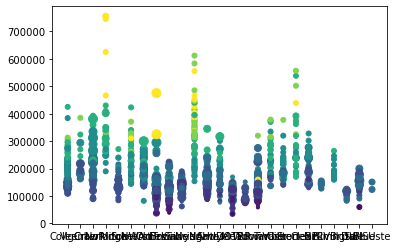

In [551]:
def scal_it(x_):
    return int(x_)**2

scat_data = train_xy[['OverallQual', 'SalePrice_real', 'Neighborhood', 'OverallCond']]
scat_data['x'] = scat_data['OverallQual'].apply(lambda x: scal_it(x))
scat_data['c'] = scat_data['OverallCond'].apply(lambda x: scal_it(x))

plt.scatter(data=scat_data, x='Neighborhood',c='x', s='c', y='SalePrice_real')#, c='Neighborhood')
#plt.plot(x=plot_scat['OverallQual'], y=plot_scat['SalePrice' ], color=plot_scat['Neighborhood'])


CollgCr


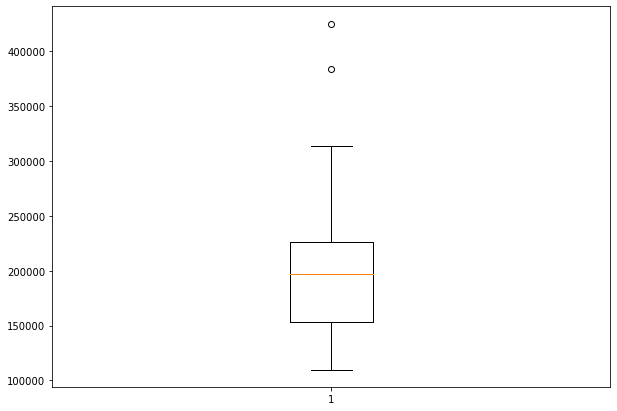

Veenker


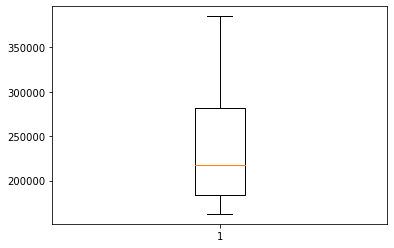

Crawfor


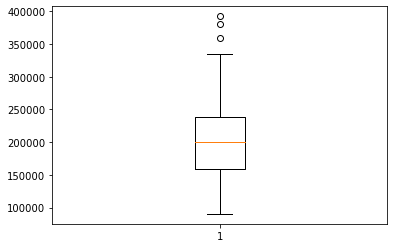

NoRidge


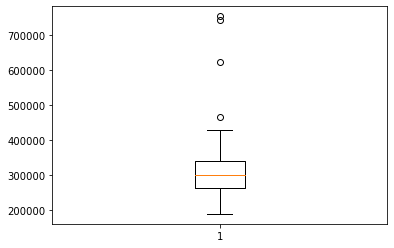

Mitchel


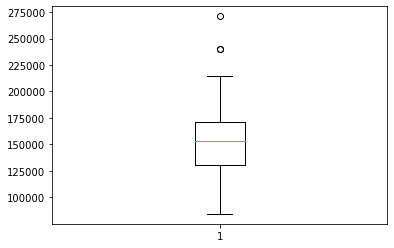

Somerst


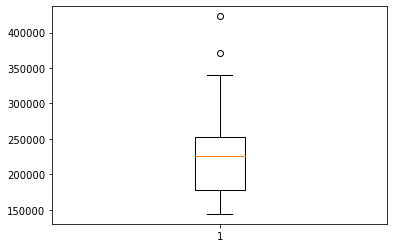

NWAmes


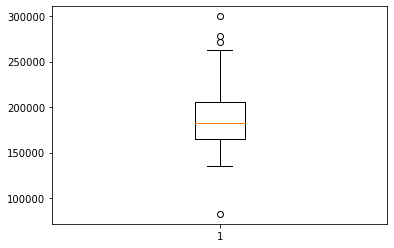

OldTown


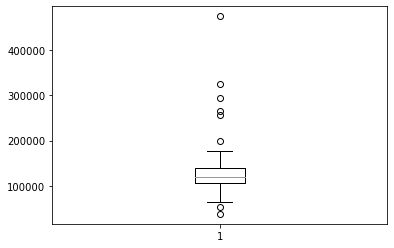

BrkSide


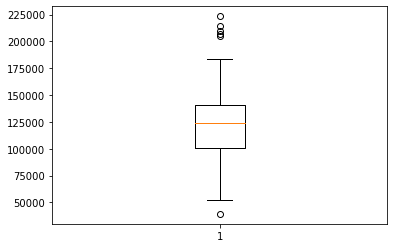

Sawyer


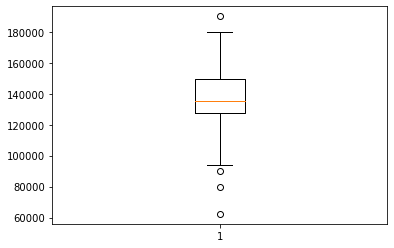

NridgHt


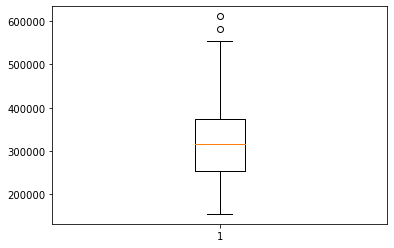

NAmes


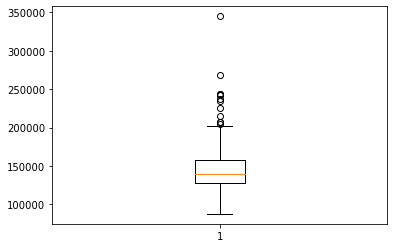

SawyerW


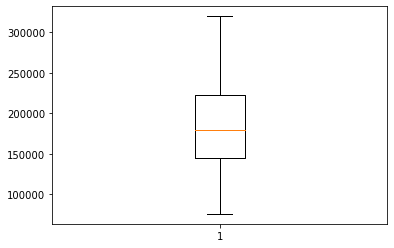

IDOTRR


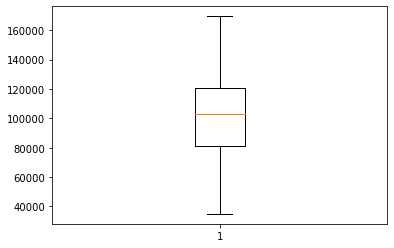

MeadowV


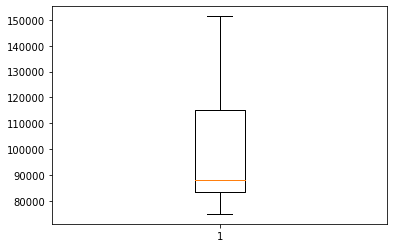

Edwards


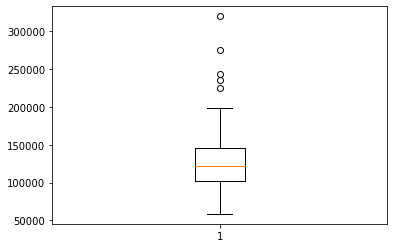

Timber


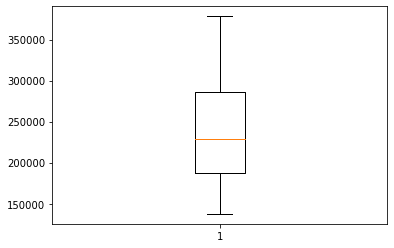

Gilbert


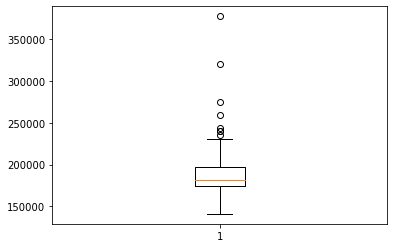

StoneBr


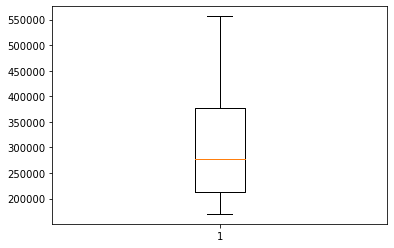

ClearCr


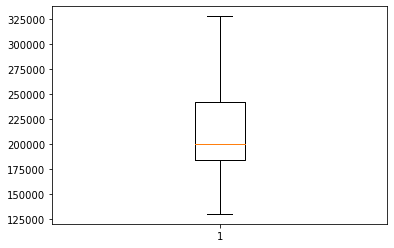

NPkVill


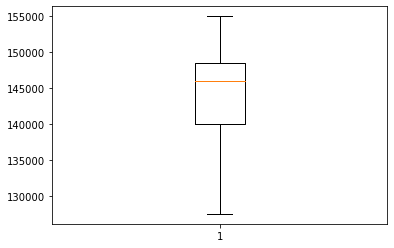

Blmngtn


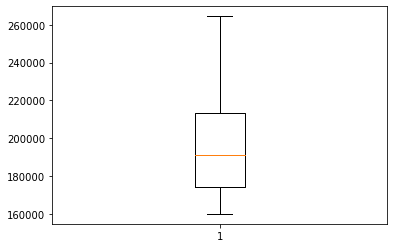

BrDale


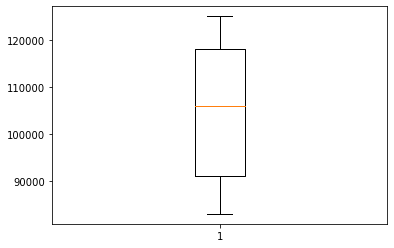

SWISU


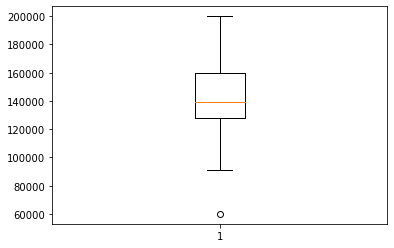

Blueste


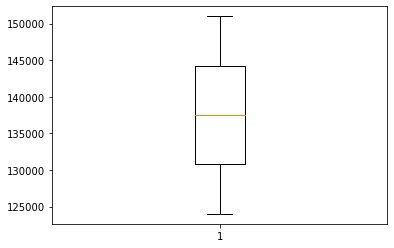

In [552]:
fig = plt.figure(figsize=(10,7))
for neigh_ in scat_data['Neighborhood'].unique():
    print(neigh_)
    plt.boxplot(scat_data.loc[scat_data['Neighborhood']==neigh_]['SalePrice_real'])
    plt.show()

    

<AxesSubplot:title={'center':'SalePrice_real'}, xlabel='Neighborhood'>

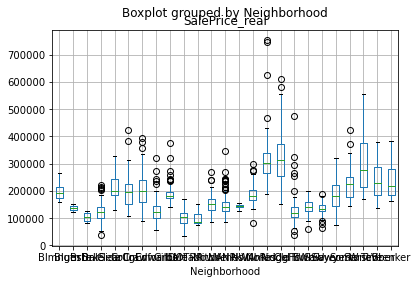

In [556]:
scat_data.boxplot(column='SalePrice_real', by='Neighborhood')

In [580]:
bp_data = scat_data[scat_data['Neighborhood']
                    .isin (['NAmes', 'CollgCr', 'OldTown', 'Edwards'])]
lst=[]
neigh = []
for neigh_ in bp_data['Neighborhood'].unique():
    print(neigh_)
    neigh.append(bp_data.loc[bp_data['Neighborhood']==neigh_]['SalePrice_real'])#, Neighborhood])

CollgCr
OldTown
NAmes
Edwards


In [581]:
neigh


[0       208500
 2       223500
 13      279500
 22      230000
 32      179900
          ...  
 1410    230000
 1422    136500
 1441    149300
 1444    179600
 1447    240000
 Name: SalePrice_real, Length: 150, dtype: int64,
 8       129900
 48      113000
 63      140000
 68       80000
 74      107400
          ...  
 1408    125500
 1416    122500
 1428    119000
 1432     64500
 1438    149700
 Name: SalePrice_real, Length: 113, dtype: int64,
 14      157000
 16      149000
 19      139000
 26      134800
 28      207500
          ...  
 1427    140000
 1435    174000
 1436    120500
 1450    136000
 1458    142125
 Name: SalePrice_real, Length: 225, dtype: int64,
 39       82000
 97       94750
 98       83000
 110     136900
 117     155000
          ...  
 1384    105000
 1423    274970
 1448    112000
 1452    145000
 1459    147500
 Name: SalePrice_real, Length: 100, dtype: int64]

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


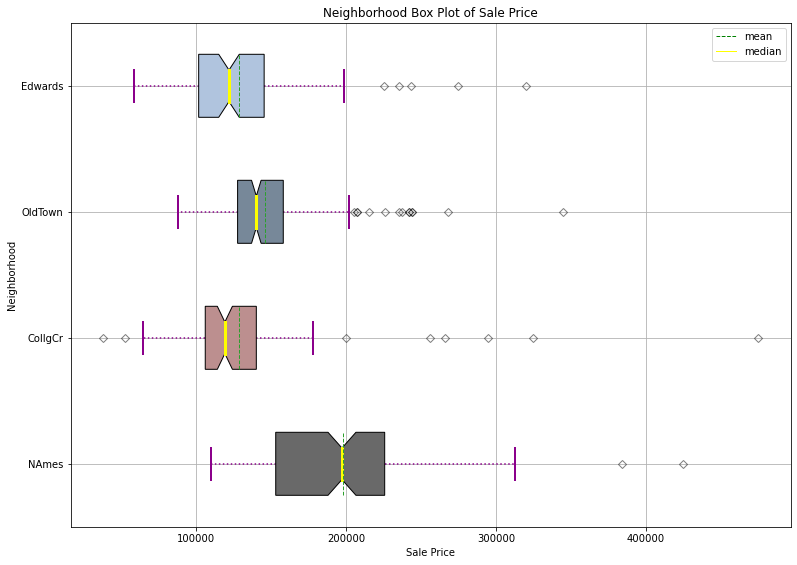

In [636]:
fig, ax = plt.subplots(figsize=(10,7)) 
#ax = fig.add_subplot(111) 
ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot(neigh, patch_artist=True,
               notch = "True", vert=0, showmeans=True, meanline=True, widths=0.5)
#bp = ax.boxplot(bp_data, column='SalePrice_real', by='Neighborhood', patch_artist=True, notch = "True", vert=0)
#bp = bp_data.boxplot(column='SalePrice_real', by='Neighborhood',patch_artist=True,
#               notch = "True", vert=0)
#ax = fig.add_axes([0, 0, 1, 1])
colors = ['dimgrey', 'rosybrown',  
          'lightslategray', 'lightsteelblue'] 
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color)
for whisker in bp['whiskers']: 
    whisker.set(color ='#8B008B', 
                linewidth = 1.5, 
                linestyle =":")
# changing color and linewidth of 
# caps 
for cap in bp['caps']: 
    cap.set(color ='#8B008B', 
            linewidth = 2) 
    
    # changing color and linewidth of 
# medians 
for median in bp['medians']: 
    median.set(color ='yellow', 
               linewidth = 3)
# changing style of fliers 
for flier in bp['fliers']: 
    flier.set(marker ='D', 
              color ='#e7298a', 
              alpha = 0.5) 
# x-axis labels 
col_ = ['NAmes', 'CollgCr', 'OldTown', 'Edwards']
ax.set_yticklabels(col_)#['data_1'])#, 'data_2',  
                    #'data_3', 'data_4']) 
 #
color_ = 'Black'
#for ax in axes:
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set_yticks([y+1 for y in range(len(col_)*2)])
ax.set_xlabel('Sale Price', color=color_)
ax.set_ylabel('Neighborhood', color=color_)
#
# Adding title  
plt.title("Neighborhood Box Plot of Sale Price", color=color_) 
# Removing top axes and right axes 
# ticks 
ax.get_xaxis().tick_bottom() 
ax.get_yaxis().tick_left() 
ax.tick_params(colors='black')

plt.plot([], [], '--', linewidth=1, color='green', label='mean')
plt.plot([], [], '-', linewidth=1, color='yellow', label='median')
fig.tight_layout()
plt.legend()

fig.savefig('neigh_boxplot.png', bbox_inches='tight')
plt.show()

In [474]:
# Buy Low
print(train_xy.loc[train_xy['Neighborhood']=='NAmes'][['Neighborhood','SalePrice_real', 'OverallQual']]
      .dropna().round())
#CategoricalDtype

print(train_xy.loc[train_xy['Neighborhood']=='NAmes'][['Neighborhood','SalePrice_real', 'OverallQual']]
      .groupby('OverallQual').agg({'OverallQual':'count', 'SalePrice_real': 'mean'}).dropna().round())

     Neighborhood  SalePrice_real OverallQual
14          NAmes          157000           6
16          NAmes          149000           6
19          NAmes          139000           5
26          NAmes          134800           5
28          NAmes          207500           5
...           ...             ...         ...
1427        NAmes          140000           5
1435        NAmes          174000           6
1436        NAmes          120500           4
1450        NAmes          136000           5
1458        NAmes          142125           5

[225 rows x 3 columns]
             OverallQual  SalePrice_real
OverallQual                             
3                      3         91300.0
4                     20        114855.0
5                    113        136949.0
6                     74        155057.0
7                     12        203933.0
8                      3        282667.0


In [455]:
for k,v in sort_dict(val).items():
    print(k,v)
    count_.append(k)
    print(train_xy.loc[train_x['Neighborhood']=='CollgCr'][['Neighborhood','SalePrice_real', k]].groupby(k, dropna=True)
          .agg({k:'count', 'SalePrice_real': 'mean'}))#count())
    print(train_raw.loc[train_x['Neighborhood']=='CollgCr'][['Neighborhood','SalePrice', k]].groupby(k)
          .agg({k:'count', 'SalePrice': 'mean'}))
print('*'*100)



#for k, val_ in  

ExterQual 0.07471850389812318
           ExterQual  SalePrice_real
ExterQual                           
Ex                 0             NaN
Fa                 0             NaN
Gd               109   212567.119266
TA                41   159147.560976
           ExterQual      SalePrice
ExterQual                          
Gd               109  212567.119266
TA                41  159147.560976
FullBath 0.07325428358108624
          FullBath  SalePrice_real
FullBath                          
0                0             NaN
1               38   137334.210526
2              111   216678.342342
3                1   424870.000000
          FullBath      SalePrice
FullBath                         
1               38  137334.210526
2              111  216678.342342
3                1  424870.000000
OverallQual 0.07266464373424437
             OverallQual  SalePrice_real
OverallQual                             
1                      0             NaN
10                     0             NaN

TA                    29  232317.413793
OpenPorchSF 0.01570571873384568
                OpenPorchSF  SalePrice_real
OpenPorchSF                                
(-0.001, 25.0]           52   157556.500000
(25.0, 50.0]             39   216813.589744
(50.0, 98.0]             35   203208.800000
(98.0, 547.0]            24   247245.416667
             OpenPorchSF      SalePrice
OpenPorchSF                            
0                     44  149988.068182
18                     1  189000.000000
20                     2  206520.500000
22                     1  176432.000000
23                     1  200000.000000
...                  ...            ...
170                    1  274300.000000
184                    2  309485.000000
211                    1  237000.000000
234                    1  213000.000000
262                    1  232000.000000

[68 rows x 2 columns]
2ndFlrSF 0.015373757077435764
                 2ndFlrSF  SalePrice_real
2ndFlrSF                                 
(-0.001

In [129]:
X_t_encoded

,"LotArea_(11601.5, 215245.0]","LotArea_(1299.999, 7553.5]","LotArea_(7553.5, 9478.5]","LotArea_(9478.5, 11601.5]",LotShape_0,LotShape_1,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,"YearBuilt_(1871.999, 1954.0]","YearBuilt_(1954.0, 1973.0]","YearBuilt_(1973.0, 2000.0]","YearBuilt_(2000.0, 2010.0]",MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_nan,"MasVnrArea_(-0.001, 164.25]","MasVnrArea_(164.25, 1600.0]",ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_0,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,"1stFlrSF_(1087.0, 1391.25]","1stFlrSF_(1391.25, 4692.0]","1stFlrSF_(333.999, 882.0]","1stFlrSF_(882.0, 1087.0]","2ndFlrSF_(-0.001, 728.0]","2ndFlrSF_(728.0, 2065.0]","GrLivArea_(1129.5, 1464.0]","GrLivArea_(1464.0, 1776.75]","GrLivArea_(1776.75, 5642.0]","GrLivArea_(333.999, 1129.5]",FullBath_0,FullBath_1,FullBath_2,FullBath_3,HalfBath_0,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,KitchenAbvGr_0,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,KitchenQual_1,KitchenQual_2,KitchenQual_3,TotRmsAbvGrd_1,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_0,FireplaceQu_1,FireplaceQu_2,FireplaceQu_3,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,PavedDrive_N,PavedDrive_P,PavedDrive_Y,"OpenPorchSF_(-0.001, 25.0]","OpenPorchSF_(25.0, 68.0]","OpenPorchSF_(68.0, 547.0]",Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,"MiscVal_(-0.001, 15500.0]",MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0

## Setup the charts for presentation

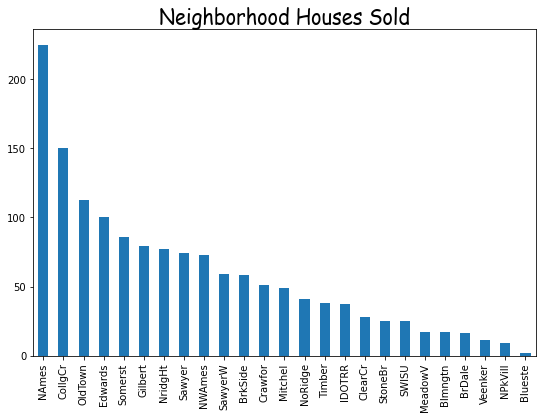

In [456]:
fig = plt.figure()
ax=train_raw['Neighborhood'].value_counts().plot(kind = 'bar',  
                                                  figsize=(9,6)) #.sort_index() after counts()
ax.set_title('Neighborhood Houses Sold', fontname='Comic Sans MS', fontsize=20)
fig.savefig('house_sold_by_neighborhood.png')

In [462]:
train_xy

,MSZoning,LotArea,LotShape,LandContour,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,Heating,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,OpenPorchSF,Fence,MiscFeature,MiscVal,MoSold,YrSold,SalePrice,SalePrice_real
0,RL,"(8400.0, 9478.5]",1,Lvl,CollgCr,1Fam,2Story,7,5,"(1994.0, 2004.0]",BrkFace,"(93.333, 243.833]",Gd,0,PConc,3,2,GasA,Y,"(816.0, 948.333]","(846.0, 2065.0]","(1664.667, 1958.0]",2,1,3,1,3,8,0,0,Attchd,RFn,2,2,2,Y,"(50.0, 98.0]",NA,NA,"(-0.001, 15500.0]",2,2008,8,208500
1,RL,"(9478.5, 10766.0]",1,Lvl,Veenker,1Fam,1Story,6,8,"(1973.0, 1994.0]",None,"(-0.001, 93.333]",TA,0,CBlock,3,2,GasA,Y,"(1087.0, 1266.0]","(-0.001, 600.0]","(1242.667, 1464.0]",2,0,3,1,2,6,1,2,Attchd,RFn,2,2,2,Y,"(-0.001, 25.0]",NA,NA,"(-0.001, 15500.0]",5,2007,7,181500
2,RL,"(10766.0, 12799.667]",0,Lvl,CollgCr,1Fam,2Story,7,5,"(1994.0, 2004.0]",BrkFace,"(93.333, 243.833]",Gd,0,PConc,3,2,GasA,Y,"(816.0, 948.333]","(846.0, 2065.0]","(1664.667, 1958.0]",2,1,3,1,3,6,1,2,Attchd,RFn,2,2,2,Y,"(25.0, 50.0]",NA,NA,"(-0.001, 15500.0]",9,2008,8,223500
3,RL,"(9478.5, 10766.0]",0,Lvl,Crawfor,1Fam,2Story,7,5,"(1871.999, 1940.0]",None,"(-0.001, 93.333]",TA,0,BrkTil,2,3,GasA,Y,"(948.333, 1087.0]","(600.0, 846.0]","(1664.667, 1958.0]",1,0,3,1,3,7,1,3,Detchd,Unf,3,2,2,Y,"(25.0, 50.0]",NA,NA,"(-0.001, 15500.0]",2,2006,5,140000
4,RL,"(12799.667, 215245.0]",0,Lvl,NoRidge,1Fam,2Story,8,5,"(1994.0, 2004.0]",BrkFace,"(243.833, 1600.0]",Gd,0,PConc,3,2,GasA,Y,"(1087.0, 1266.0]","(846.0, 2065.0]","(1958.0, 5642.0]",2,1,4,1,3,9,1,2,Attchd,RFn,3,2,2,Y,"(50.0, 98.0]",NA,NA,"(-0.001, 15500.0]",12,2008,9,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,"(6405.0, 8400.0]",1,Lvl,Gilbert,1Fam,2Story,6,5,"(1994.0, 2004.0]",None,"(-0.001, 93.333]",TA,0,PConc,3,2,GasA,Y,"(948.333, 1087.0]","(600.0, 846.0]","(1464.0, 1664.667]",2,1,3,1,2,7,1,2,Attchd,RFn,2,2,2,Y,"(25.0, 50.0]",NA,NA,"(-0.001, 15500.0]",8,2007,6,175000
1456,RL,"(12799.667, 215245.0]",1,Lvl,NWAmes,1Fam,1Story,6,6,"(1973.0, 1994.0]",Stone,"(93.333, 243.833]",TA,0,CBlock,3,2,GasA,Y,"(1535.833, 4692.0]","(-0.001, 600.0]","(1958.0, 5642.0]",2,0,3,1,2,7,2,2,Attchd,Unf,2,2,2,Y,"(-0.001, 25.0]",MnPrv,NA,"(-0.001, 15500.0]",2,2010,8,210000
1457,RL,"(8400.0, 9478.5]",1,Lvl,Crawfor,1Fam,2Story,7,9,"(1940.0, 1960.0]",None,"(-0.001, 93.333]",Ex,0,Stone,2,3,GasA,Y,"(1087.0, 1266.0]","(846.0, 2065.0]","(1958.0, 5642.0]",2,0,4,1,3,9,2,3,Attchd,RFn,1,2,2,Y,"(50.0, 98.0]",GdPrv,Shed,"(-0.001, 15500.0]",5,2010,10,266500
1458,RL,"(9478.5, 10766.0]",1,Lvl,NAmes,1Fam,1Story,5,6,"(1940.0, 1960.0]",None,"(-0.001, 93.333]",TA,0,CBlock,2,2,GasA,Y,"(948.333, 1087.0]","(-0.001, 600.0]","(1026.0, 1242.667]",1,0,2,1,3,5,0,0,Attchd,Unf,1,2,2,Y,"(-0.001, 25.0]",NA,NA,"(-0.001, 15500.0]",4,2010,5,142125


In [671]:
scat_data

,OverallQual,SalePrice_real,Neighborhood,OverallCond,x,c
0,7,208500,CollgCr,5,49,25
1,6,181500,Veenker,8,36,64
2,7,223500,CollgCr,5,49,25
3,7,140000,Crawfor,5,49,25
4,8,250000,NoRidge,5,64,25
...,...,...,...,...,...,...
1455,6,175000,Gilbert,5,36,25
1456,6,210000,NWAmes,6,36,36
1457,7,266500,Crawfor,9,49,81
1458,5,142125,NAmes,6,25,36


NameError: name 'df_' is not defined

In [795]:
def rolling_mean(df_col):
    return df_col.rolling_mean(window=90).mean()




def get_plot():
    for i, neigh_ in enumerate(FOUR_NEIGHBORHOODS):
        df_ = (four_neigh_group.loc[four_neigh_group['Neighborhood']==neigh_]
                .groupby(['Date']).agg({'SalePrice_real': 'mean'}).round().reset_index()
              )
        df_['Rolling_60'] = df_.rolling(4).mean().shift(-2)
        
        plt.plot(df_['Rolling_60'],
            label=neigh_,
            color = colors[i],
            linewidth=3)

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: This figure includes Axes that 

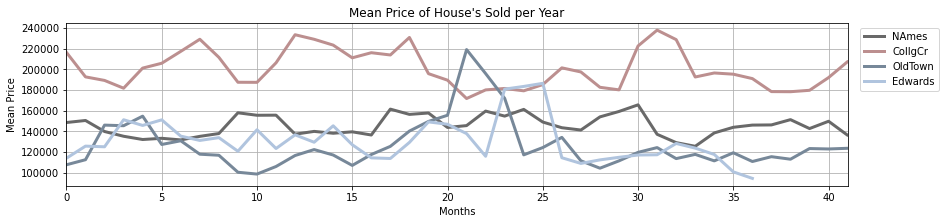

0      2008-02-01
2      2008-09-01
8      2008-04-01
13     2007-08-01
14     2008-05-01
          ...    
1448   2007-05-01
1450   2009-09-01
1452   2006-05-01
1458   2010-04-01
1459   2008-06-01
Name: Date, Length: 588, dtype: datetime64[ns]


In [829]:
FOUR_NEIGHBORHOODS = ['NAmes', 'CollgCr', 'OldTown', 'Edwards']
four_neigh_group = train_xy[train_xy['Neighborhood'].isin(FOUR_NEIGHBORHOODS)]
four_neigh_group['dateInt']=four_neigh_group['YrSold'].astype(str) + four_neigh_group['MoSold'].astype(str).str.zfill(2)+ '1'.zfill(2)
four_neigh_group['Date'] = pd.to_datetime(four_neigh_group['dateInt'], format='%Y%m%d')
four_neigh_group['Date']
plt.figure(figsize=(14,3))
fig.tight_layout()
for i, neigh_ in enumerate(FOUR_NEIGHBORHOODS):
    df_ = (four_neigh_group.loc[four_neigh_group['Neighborhood']==neigh_]
            .groupby(['Date']).agg({'SalePrice_real': 'mean'}).round().reset_index()
          )
    df_['Rolling_3_months'] = df_.rolling(3).mean().shift(-2)

    plt.plot(df_['Rolling_3_months'],
        label=neigh_,
        color = colors[i],
        linewidth=3)

#plt.xticks(np.arange(0,36))#, step=6))
plt.xlabel('Months') 
plt.ylabel('Mean Price')
plt.title("Mean Price of House's Sold per Year")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.5)
plt.grid('True')
#plt.axis([0,41])
plt.xlim(0,41)
plt.savefig('Mean_price_3_mon_rolling.png')
plt.show()#.plot.line())
#four_neigh_group.groupby(['YrSold', 'Neighborhood']).agg({'SalePrice_real':'mean'}).plot.line(y='SalePrice_real',by='Neighborhood')
#for neigh_ i

print(four_neigh_group['Date'])

In [816]:
print(four_neigh_group['Neighborhood'].unique)#.groupby('Neighborhood')['SalePrice_real'])

<bound method Series.unique of 0       CollgCr
2       CollgCr
8       OldTown
13      CollgCr
14        NAmes
         ...   
1448    Edwards
1450      NAmes
1452    Edwards
1458      NAmes
1459    Edwards
Name: Neighborhood, Length: 588, dtype: category
Categories (25, object): ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', ..., 'Somerst', 'StoneBr', 'Timber', 'Veenker']>


In [673]:
for neigh_ in bp_data['Neighborhood'].unique():
    print(neigh_)
    neigh.append(bp_data.loc[bp_data['Neighborhood']==neigh_][['SalePrice_real', 'YrSold']])

CollgCr


KeyError: "['YrSold'] not in index"

In [638]:
NAmes=train_xy.loc[train_xy['Neighborhood']=='NAmes']

In [650]:
def group_it(df, grps):
    return df.groupby(grps).agg({'SalePrice_real':['count', 'mean']}).round().dropna()

In [651]:
group_it(NAmes, 'BedroomAbvGr')

SalePrice_real          
                      count      mean
BedroomAbvGr                         
1                         2  139500.0
2                        57  129410.0
3                       131  145588.0
4                        28  176939.0
5                         3  177100.0
6                         4  150650.0

In [464]:
train_xy.groupby('SalePrice').agg({'SalePrice_real':['count', 'mean']}).round()

SalePrice_real          
                   count      mean
SalePrice                         
0                      0       NaN
1                      5   37482.0
2                     23   64469.0
3                    103   90276.0
4                    226  117798.0
5                    295  140972.0
6                    248  168242.0
7                    162  192450.0
8                    115  219437.0
9                     84  243911.0
10                    63  270244.0
11                    31  294398.0
12                    38  320460.0
13                    16  345312.0
14                    17  376385.0
15                    11  399464.0
16                     6  426054.0
17                     4  444248.0
18                     4  472875.0
19                     1  501837.0
20                     1  538000.0
21                     2  555790.0
22                     1  582933.0
23                     1  611657.0
24                     1  625000.0
25                     0       NaN
26                     0       NaN
27                     0       NaN
28                     1  745000.0
29                     1  755000.0
30                     0       NaN